In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

import shutil

from IS2ML_utils import *
from figscode import *

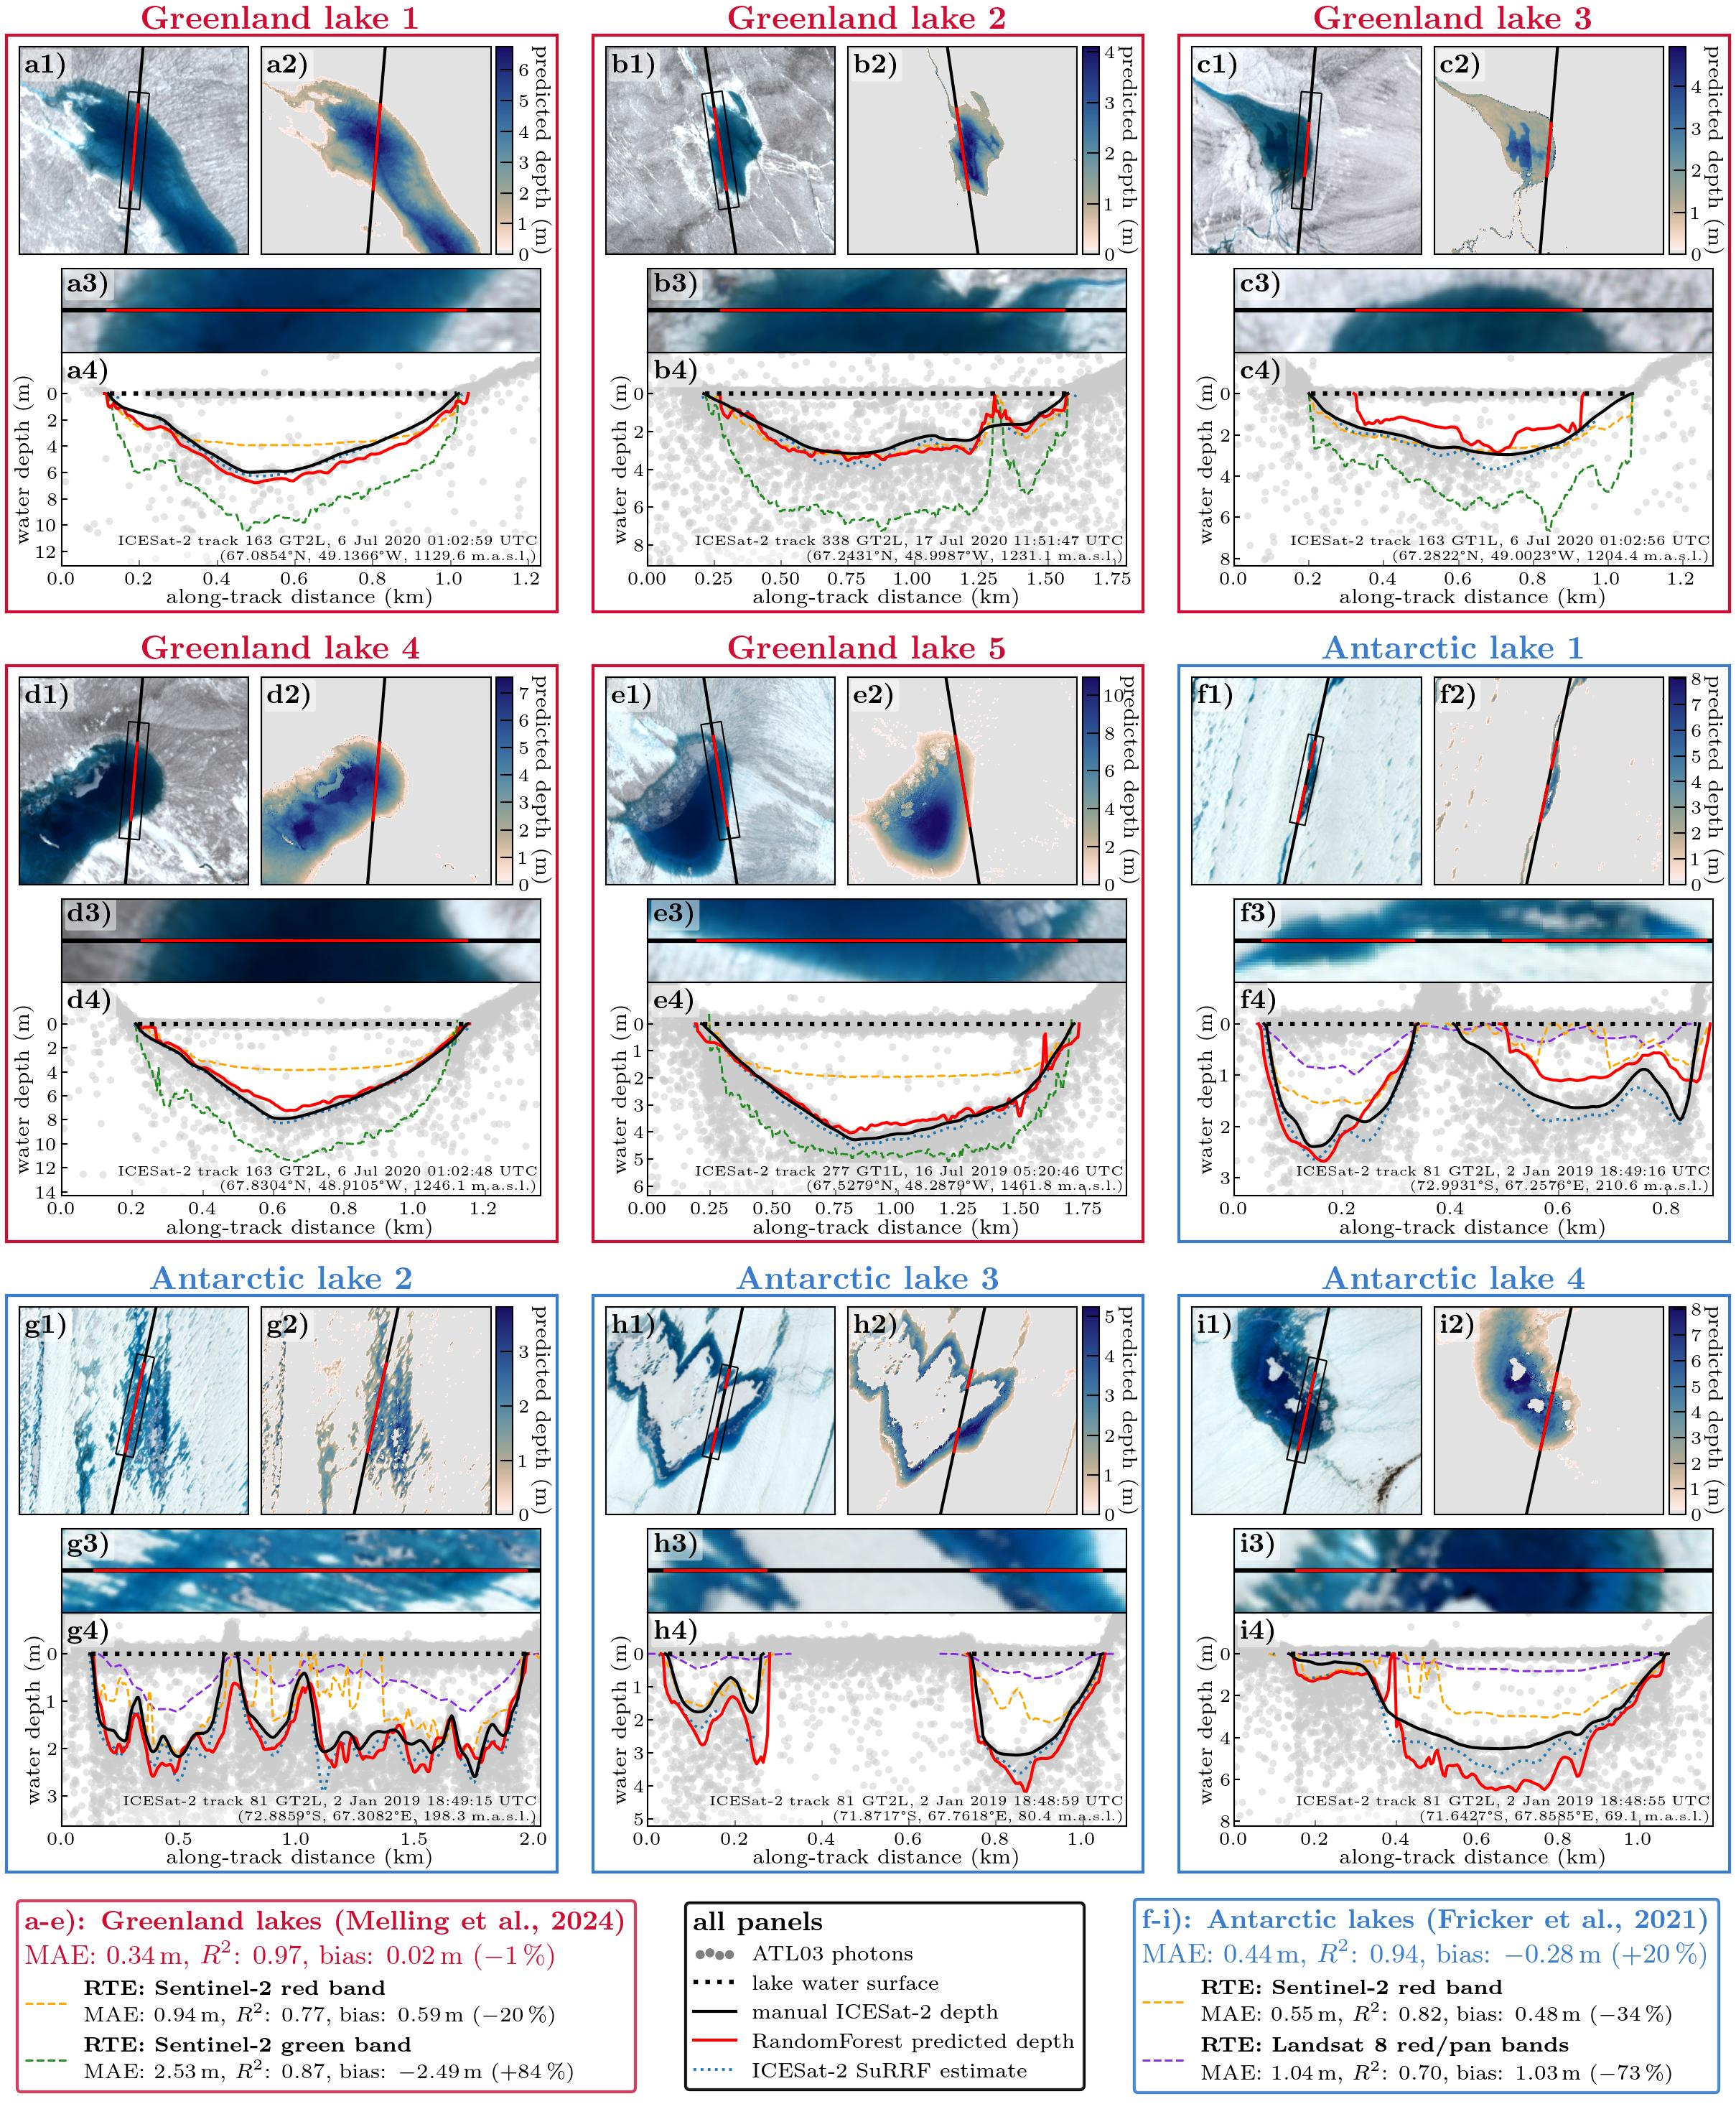


GrIS stats:


,bias,std,mae,rmse,R,percent
predicted_depth,0.021349,0.480061,0.336845,0.480536,0.970978,-1.0
Red_z_lit,0.590177,1.168893,0.942629,1.309435,0.772929,-20.0
Green_z_lit,-2.491145,1.235268,2.527558,2.780592,0.873265,84.3



AIS stats:


,bias,std,mae,rmse,R,percent
predicted_depth,-0.284561,0.613872,0.438394,0.676619,0.941445,20.3
RTE_Landsat8_red_pan,1.029048,0.999333,1.035934,1.434436,0.700852,-73.3
RTE_Sentinel2_red,0.482435,0.707437,0.554685,0.856278,0.819921,-34.4


In [2]:
#### to re-compile all data from the sources
# compile_IS2_comparison_data()

fn_data = 'data/is2comp/comparison_melling_fricker.csv'
df_data = pd.read_csv(fn_data)

df_data['is_greenland'] =  df_data.id_lake.apply(lambda x: 'greenland' in x)
dfsel = df_data[df_data.is_greenland]
sts = []
for stat in ['predicted_depth', 'Red_z_lit', 'Green_z_lit']:
    sts.append(getstats_comparison(dfsel, stat, verb=False))
stats_gris = pd.concat(sts)

dfsel = df_data[~df_data.is_greenland]
sts = []
for stat in ['predicted_depth', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']:
    sts.append(getstats_comparison(dfsel, stat, verb=False))
stats_ais = pd.concat(sts)

datadir = 'data/is2comp/h5/'
list_h5 = [datadir+f for f in os.listdir(datadir) if os.path.isfile(os.path.join(datadir, f)) & ('.h5' in f)]
list_h5.sort()
list_h5 = [x for x in list_h5 if 'lake_greenland_melling_' in x] + [x for x in list_h5 if 'lake_amery_fricker_' in x]
list_ids = [x.split('/')[-1].replace('.h5', '') for x in list_h5]
dffiles = pd.DataFrame({'id': list_ids, 'h5': list_h5})
dffiles['tiff'] = dffiles.id.apply(lambda x: 'data/is2comp/imagery/%s_ensemble_depth_estimates.tiff' % x)
dffiles['rotated'] = dffiles.id.apply(lambda x: 'data/is2comp/rotated_images/%s.tiff' % x)

plt.close('all')
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    'font.size': 6,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

labelsize = 7

colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}

figwid = 8.5
fighgt = 10
fig = plt.figure(figsize=[figwid,fighgt])
nh = 3
gs = fig.add_gridspec(ncols=3, nrows=3*nh+1)
axbxs = []
for i in range(9):
    axbxs.append(fig.add_subplot(gs[nh*int(i/3):nh*int(i/3)+nh, i%3]))
    axbxs[-1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axbxs[-1].patch.set_facecolor('none')
    for spine in axbxs[-1].spines.values():
        spine.set_zorder(100)
        
axleg_box = fig.add_subplot(gs[nh*3, :])
axleg_box.axis('off')

fig.tight_layout(pad=3, h_pad=3, w_pad=2)

def ith_letter(i):
        return chr(97 + i)
    
htop = 0.38
hbot = 0.45
pad_l = 0.1
pad_r = 0.03
pad_b = 0.08
pad_top = 0.02
pad_mid = pad_top * fighgt / figwid
pad_cbar = 0.01
pad_cbarlabel = 0.08
wid_cbar = 0.03
pad_vert = 0.025

zoom_imgs = 0.65

plot_melling = ['manual', 'predicted_depth', 'surrf_2024', 'Green_z_lit', 'Red_z_lit']
plot_fricker = ['manual', 'predicted_depth', 'surrf_2024', 'RTE_Landsat8_red_pan', 'RTE_Sentinel2_red']
depth_keys = list(set(plot_melling + plot_fricker))

ref_idx = 1.336

cmap_img = cmc.lapaz_r

axs = []
for axbx in axbxs:
    axs_ = []
    wid_top = (1 - 2*pad_mid - pad_cbar - wid_cbar - pad_cbarlabel)/2
    axs_.append(axbx.inset_axes([pad_mid, 1-htop, wid_top, htop-pad_top])) # TCI full
    axs_.append(axbx.inset_axes([pad_mid*2+wid_top, 1-htop, wid_top, htop-pad_top], sharex=axs_[-1], sharey=axs_[-1])) # depth est full
    axs_.append(axbx.inset_axes([pad_mid*2+wid_top*2+pad_cbar, 1-htop, wid_cbar, htop-pad_top])) # colorbar 
    h_mid = 1 - (htop + hbot + pad_vert)
    axs_.append(axbx.inset_axes([pad_l, hbot, 1-(pad_l + pad_r), h_mid])) # along-track TCI
    axs_.append(axbx.inset_axes([pad_l, pad_b, 1-(pad_l + pad_r), hbot-pad_b], sharex=axs_[-1])) # along-track data
    for axx in axs_[:4]:
        axx.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        for spine in axx.spines.values():
            spine.set_zorder(100)
    axs.append(axs_)

# for ilk, axset in enumerate([axs[i] for i in [0, 5]]):
for ilk, axset in enumerate(axs):
    
    files = dffiles.loc[ilk]
    id = files.id
    thisletter = ith_letter(ilk)

    source = id.split('_')[2]
    source_txt = 'Fricker et al., 2021' if source=='fricker' else 'Melling et al., 2024'
    location = 'Antarctic' if source=='fricker' else 'Greenland'
    axcolor = colors['AIS'] if source=='fricker' else colors['GrIS']

    # photon data and lake elevation / info
    lk = dictobj(read_melt_lake_h5(files.h5))
    df_phot = lk.photon_data.copy()
    hsurf = lk.surface_elevation
    date_time = lk.date_time
    afterpulse = df_phot.prob_afterpulse > np.random.uniform(0,1,len(df_phot))
    df_phot = df_phot[~afterpulse].copy().reset_index(drop=True)
    df_phot.loc[df_phot.h < hsurf, 'h'] = hsurf - (hsurf - df_phot.loc[df_phot.h < hsurf, 'h']) / ref_idx
    
    thisdf = df_data[df_data.id_lake==id].copy().sort_values(by='dist_along_track_m').reset_index(drop=True)
    gdf = gpd.GeoDataFrame(thisdf, geometry=gpd.points_from_xy(thisdf.lon, thisdf.lat), crs="EPSG:4326")
    img = rio.open(files.tiff)
    gdf = gdf.to_crs(img.crs)
    gdf[['x', 'y']] = gdf.geometry.get_coordinates()
    xoff = np.nanmin(thisdf['dist_along_track_m'])
    df_phot.xatc -= xoff
    gdf.dist_along_track_m -= xoff
    gdf['xatc'] = gdf.dist_along_track_m / 1000
    manual_nodepth = gdf.manual <= 0
    predict_nodepth = gdf.predicted_depth <= 0
    max_depth = gdf[depth_keys].max().max()
    xl_track = (0.0, np.nanmax(gdf.xatc))
    yl_track = (1.25 * max_depth, -0.3 * max_depth)
    
    ax = axset[0]
    xl_img, yl_img = get_xylims_aspect(ax, img, fig)
    rgb = img.read([4,3,2])
    rgbmin = np.percentile(rgb, 0.2)
    rgbmax = np.percentile(rgb, 97) - rgbmin
    rgb = np.clip((rgb-rgbmin) / rgbmax, 0, 1) * 255
    rgb = rgb.astype(np.uint8)
    rioplot.show(rgb, ax=ax, transform=img.transform)
    ax.set_xlim(xl_img)
    ax.set_ylim(yl_img)

    ax = axset[1]
    depth = img.read(1)
    depthmin = 0
    depthmax = np.percentile(depth, 99.9)
    rioplot.show(depth, ax=ax, transform=img.transform, vmin=0, vmax=depthmax, cmap=cmap_img)
    depth0 = depth
    depth0[depth0 > 0.1] = np.nan
    nan_val = 0.1
    depth0[~np.isnan(depth0)] = nan_val
    rioplot.show(depth0, ax=ax, transform=img.transform, cmap=cmc.grayC, vmin=0, vmax=1)
    cax = axset[2]
    sm = plt.cm.ScalarMappable(cmap=cmap_img, norm=plt.Normalize(vmin=0, vmax=depthmax))
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cax.axhline(0, lw=3, color=cmc.grayC(nan_val))
    labpad = 4 if depthmax < 10 else 1
    cbar.set_label('predicted depth (m)', labelpad=labpad, fontsize=labelsize, rotation=270, rotation_mode='anchor', ha='center', va='center')
    cbar.ax.tick_params(axis='y', direction='in', length=4, width=0.5, pad=2)
    cax.yaxis.set_major_locator(MaxNLocator(integer=True))

    dx = gdf.x.iloc[-1] - gdf.x.iloc[0]
    dy = gdf.y.iloc[-1] - gdf.y.iloc[0]
    gt_x = [gdf.x.iloc[0] + ix * dx for ix in range(-5, 5)]
    gt_y = [gdf.y.iloc[0] + iy * dy for iy in range(-5, 5)]
    xnan = gdf.x.copy()
    xnan[predict_nodepth] = np.nan
    for ax in axset[:2]:
        ax.plot(gt_x, gt_y, color='k', lw=1)
        ax.plot(xnan, gdf.y, color='r', lw=1, solid_capstyle='butt')
        if zoom_imgs != 1:
            xmid = np.mean(xl_img)
            ymid = np.mean(yl_img)
            xrng = np.diff(xl_img)[0]
            yrng = np.diff(yl_img)[0]
            ax.set_xlim([xmid - xrng/2*zoom_imgs, xmid + xrng/2*zoom_imgs])
            ax.set_ylim([ymid - yrng/2*zoom_imgs, ymid + yrng/2*zoom_imgs])

    ax = axset[3]
    axbbx = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axis_aspect = axbbx.height / axbbx.width
    img_ylim_range = (xl_track[1] - xl_track[0]) * axis_aspect / 2
    yl_gtimage = (-img_ylim_range, img_ylim_range)
    ax.set_ylim(yl_gtimage)
    ax.set_xlim(xl_track)
    with rio.open(files.rotated) as src:
        rioplot.show(src, ax=ax)
        gt_plot_bounds = src.bounds
        gt_plot_crs = src.crs
    ax.axhline(0, color='k')
    zeros = gdf.x.copy() * 0.0
    zeros[predict_nodepth] = np.nan
    ax.plot(gdf.xatc, zeros, color='r', lw=1, solid_capstyle='butt')

    # get the bounding box of the ground track background image on the larger image
    ax = axset[0]
    dxdy = np.array([gdf.x.iloc[-1] - gdf.x.iloc[0], gdf.y.iloc[-1] - gdf.y.iloc[0]])
    dxdy = dxdy / np.sqrt(np.sum(dxdy**2))
    drot = np.array([dxdy[1], -dxdy[0]])
    dy = yl_gtimage[1]*1000
    start = np.array([gdf.x.iloc[0], gdf.y.iloc[0]])
    end = np.array([gdf.x.iloc[-1], gdf.y.iloc[-1]])
    bbox_gtimg = np.array([start - dy * drot, end - dy * drot, end + dy * drot, start + dy * drot, start - dy * drot])
    polygon_gtimg = gpd.GeoSeries(Polygon([tuple(row) for row in bbox_gtimg]))
    polygon_gtimg.exterior.plot(ax=ax, lw=0.5, color='k')

    # plot the along-ICESat-2-track data
    ax = axset[4]
    keys_fillna = list(set(depth_keys) - set(['surrf_2024', 'surrf_corr']))
    gdf[keys_fillna] = gdf[keys_fillna].fillna(0.0)
    for k in keys_fillna:
        to_remove = gdf[k].rolling(window=3, center=True, min_periods=1).mean() <= 0
        gdf.loc[to_remove, k] = np.nan
    gdf.loc[gdf.surrf_2024==0, 'surrf_2024'] = np.nan
    gdf.loc[gdf.surrf_corr==0, 'surrf_corr'] = np.nan
    lk_surf = gdf.xatc * 0
    lk_surf[manual_nodepth] = np.nan
    ax.scatter(df_phot.xatc/1000, -df_phot.h + hsurf, s=6, color=[0.8]*3, alpha=0.5, edgecolors='none', rasterized=True)
    p_photons = ax.scatter([-999]*4, [-999]*4, s=4, color='gray', label='ATL03 photons')
    p_lksurf, = ax.plot(gdf.xatc, lk_surf, color='k', ls=':', lw=1.5, zorder=11, label='lake water surface')
    p_manual, = ax.plot(gdf.xatc, gdf.manual, color='k', label='manual ICESat-2 depth', lw=1, zorder=10)
    p_predict, = ax.plot(gdf.xatc, gdf.predicted_depth, color='r', label='RandomForest predicted depth', lw=1, zorder=9)
    p_surrf, = ax.plot(gdf.xatc, gdf.surrf_2024, color='C0', label='ICESat-2 SuRRF estimate', ls=':', lw=0.9, zorder=8)
    if source == 'fricker':
        l8lab = '\\textbf{RTE: Landsat 8 red/pan bands}\n%s' % get_stats_string_latex(stats_ais, 'RTE_Landsat8_red_pan')
        s2lab = '\\textbf{RTE: Sentinel-2 red band}\n%s' % get_stats_string_latex(stats_ais, 'RTE_Sentinel2_red')
        p_l8, = ax.plot(gdf.xatc, gdf.RTE_Landsat8_red_pan, color='blueviolet', ls='--', label=l8lab, lw=0.7)
        p_s2, = ax.plot(gdf.xatc, gdf.RTE_Sentinel2_red, color='orange', ls='--', label=s2lab, lw=0.7)
        # p_watta, = ax.plot(gdf.xatc, hsurf-gdf.watta, color='c', ls='--', label='Watta', lw=0.7)
    if source == 'melling':
        rlab = '\\textbf{RTE: Sentinel-2 red band}\n%s' % get_stats_string_latex(stats_gris, 'Red_z_lit')
        glab = '\\textbf{RTE: Sentinel-2 green band}\n%s' % get_stats_string_latex(stats_gris, 'Green_z_lit')
        p_red_lit, = ax.plot(gdf.xatc, gdf.Red_z_lit, color='orange', ls='--', label=rlab, lw=0.7)
        p_green_lit, = ax.plot(gdf.xatc, gdf.Green_z_lit, color='forestgreen', ls='--', label=glab, lw=0.7)
        # p_red, = ax.plot(gdf.xatc, hsurf-gdf.Z_red, color='deeppink', ls='--', label='RTE: Sentinel-2 red band', lw=0.7)
        # p_green, = ax.plot(gdf.xatc, hsurf-gdf.Z_green, color='forestgreen', ls='--', label='RTE: Sentinel-2 green band', lw=0.7)
        # p_dem, = ax.plot(gdf.xatc, hsurf-gdf.DEM_zeroed, color='y', ls='--', label='ArcticDEM', lw=0.7, zorder=9)
    ax.set_xlim(xl_track)
    ax.set_ylim(yl_track)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    yticks = ax.get_yticks()
    positive_yticks = yticks[yticks >= 0]
    ax.set_yticks(positive_yticks)
    # ytcks = [x for x in ax.get_yticks() if x >=0]
    # ax.set_yticks(ytcks)
    ax.set_ylim(yl_track)
    ax.tick_params(axis='y', direction='in', length=2, pad=1, width=0.5)
    ax.tick_params(axis='x', direction='in', length=2, pad=2, width=0.5)
    ax.set_xlabel('along-track distance (km)', labelpad=0, fontsize=labelsize)
    ax.set_ylabel('water depth (m)', labelpad=1, fontsize=labelsize)
    timestr = datetime.strftime(datetime.strptime(lk.date_time, '%Y-%m-%dT%H:%M:%SZ'), '%-d %b %Y %H:%M:%S UTC')
    latlon = '%s°%s, %s°%s' % (lk.lat_str[:-2], lk.lat_str[-1], lk.lon_str[:-2], lk.lon_str[-1])
    descript = 'ICESat-2 track %i %s, %s' % (lk.rgt, lk.gtx.upper(), timestr)
    descript += '\n(%s, %.1f m.a.s.l.)' % (latlon, lk.surface_elevation)
    desc_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.3")
    # ax.text(0.5, 1.0, descript1, ha='center', va='bottom', transform=ax.transAxes, bbox=desc_bbx, fontsize=6)
    # ax.text(0.5, 1.0, descript2, ha='center', va='top', transform=ax.transAxes, bbox=desc_bbx, fontsize=6)
    ax.text(0.995, 0.01, descript, ha='right', va='bottom', transform=ax.transAxes, bbox=desc_bbx, fontsize=4.5, zorder=15)

    # axis appearance
    for iax, ax in enumerate(axset):
        if iax != 4:
            ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        for spine in ax.spines.values():
            spine.set_zorder(100)
            spine.set_linewidth(0.5)

# legends
hdls = [[p_red_lit, p_green_lit], [p_s2, p_l8], [p_photons, p_lksurf, p_manual, p_predict, p_surrf]]
tit_gre = '\\textbf{a-e): Greenland lakes (Melling et al., 2024)}\n%s' % get_stats_string_latex(stats_gris, 'predicted_depth')
tit_ais = '\\textbf{f-i): Antarctic lakes (Fricker et al., 2021)}\n%s' % get_stats_string_latex(stats_ais, 'predicted_depth')
tits = [tit_gre, tit_ais, '\\textbf{all panels}']

# legend_axes = []
# for i, ax in enumerate(axlegs):
#     legend_axes.append(ax.inset_axes([0,-0.1,1,1.3]))
axleg = axleg_box.inset_axes([0,-0.1,1,1.3])

leg_positions = ['center left','center right', 'center']
leg_xbounds = []
for i, legpos in enumerate(leg_positions):
    axleg.axis('off')
    ncols = 1
    if i == 2:
        axleg_center = axleg_box.inset_axes([leg_xbounds[0][1], -0.1, leg_xbounds[1][0]-leg_xbounds[0][1], 1.3])
        axleg_center.axis('off')
        leg = axleg_center.legend(handles=hdls[i], ncols=ncols, loc=legpos, scatterpoints=4, fontsize=7, title=tits[i], 
                       title_fontproperties={'size': 9})
        leg._legend_box.align = "left"
        axleg_center.add_artist(leg)
    else:
        leg = axleg.legend(handles=hdls[i], ncols=ncols, loc=legpos, scatterpoints=4, fontsize=7, title=tits[i], 
                       title_fontproperties={'size': 9})
        leg._legend_box.align = "left"
        axleg.add_artist(leg)
    legcolor = 'black'
    if i == 0:
        legcolor = colors['GrIS']
    elif i == 1:
        legcolor = colors['AIS']
    leg.get_frame().set_edgecolor(legcolor)
    leg.get_title().set_color(legcolor)
    bbox_data = leg.get_window_extent().transformed(axleg.transData.inverted())
    leg_xbounds.append([bbox_data.xmin, bbox_data.xmax])

for iax, ax in enumerate(axbxs):
    id = dffiles.id.loc[iax]
    axcolor = colors['AIS'] if 'fricker' in id else colors['GrIS']
    location = 'Antarctic' if 'fricker' in id else 'Greenland'
    number = id.split('_')[3]
    for spine in ax.spines.values():
        spine.set_color(axcolor)
        spine.set_linewidth(1)
    ax.text(0.5, 1.0,'\\textbf{%s lake %s}' % (location, number), color=axcolor, fontsize=11, ha='center', va='bottom',
           transform=ax.transAxes)
        
# add the letters/numbers for panels
for ilk, axset in enumerate(axs):
    thisletter = ith_letter(ilk)
    id = dffiles.id.loc[ilk]
    axcolor = colors['AIS'] if 'fricker' in id else colors['GrIS']
    for iax, ax in enumerate([axset[i] for i in [0,1,3,4]]):
        xval = 0.025 if iax < 2 else 0.013
        ax.text(xval, 0.975, '\\textbf{%s%i)}' % (thisletter, iax+1), color='black', ha='left', va='top', transform=ax.transAxes,
                fontsize=9, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.1"))

figfn = 'figures/fig04_comparison-RTE-IS2.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=80, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

print('\nGrIS stats:')
display(stats_gris)
print('\nAIS stats:')
display(stats_ais)